#### Step 1: Setup and Getting Data



In [ ]:
!nvidia-smi

Sun Dec  7 23:56:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             55W /  400W |    2489MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.7.4.2 --quiet
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"erickumara","key":"ef3183b6e235dac70c2d15665a8216d6"}')

!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# Datasets
# https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset 7 columns
# https://www.kaggle.com/datasets/llabhishekll/fraud-email-dataset 2 columns

!mkdir '/content/data'

!kaggle datasets download -d naserabdullahalam/phishing-email-dataset
!unzip -qo 'phishing-email-dataset.zip' -d '/content/data'
!rm 'phishing-email-dataset.zip'

!kaggle datasets download -d llabhishekll/fraud-email-dataset
!unzip -qo 'fraud-email-dataset.zip' -d '/content/data'
!rm 'fraud-email-dataset.zip'

mkdir: cannot create directory ‘/content/data’: File exists
Dataset URL: https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset
License(s): CC-BY-SA-4.0
Dataset URL: https://www.kaggle.com/datasets/llabhishekll/fraud-email-dataset
License(s): unknown


#### Step 2: Data-preprocessing

In [ ]:
import os

data_path = "/content/data"

all_df = []

for file in os.listdir(data_path):
    df = pd.read_csv(os.path.join(data_path, file))

    # Normalizing all datasets to columns: body, label
    if {'body', 'label'}.issubset(df.columns):
        pass
    elif {'Text', 'Class'}.issubset(df.columns):
        df = df.rename(columns={'Text':'body','Class':'label'})
    elif {'text_combined','label'}.issubset(df.columns):
        df = df.rename(columns={'text_combined':'body'})
    elif 'message' in df.columns:
        df = df.rename(columns={'message':'body'})

    df = df[['body','label']]
    all_df.append(df)

    print(f"Loaded: {file}")
    print(df.head(1))
    print("-"*40)

final_df = pd.concat(all_df, ignore_index=True)
final_df.dropna(inplace=True)
final_df['label'] = final_df['label'].astype(int)

final_df.head()


Loaded: phishing_email.csv
                                                body  label
0  hpl nom may 25 2001 see attached file hplno 52...      0
----------------------------------------
Loaded: Nigerian_Fraud.csv
                                                body  label
0  FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-2...      1
----------------------------------------
Loaded: CEAS_08.csv
                                                body  label
0  Buck up, your troubles caused by small dimensi...      1
----------------------------------------
Loaded: fraud_email_.csv
                                                body  label
0  Supply Quality China's EXCLUSIVE dimensions at...      1
----------------------------------------
Loaded: SpamAssasin.csv
                                                body  label
0  Date:        Wed, 21 Aug 2002 10:54:46 -0500  ...      0
----------------------------------------
Loaded: Enron.csv
                                                body  

,body,label
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0


In [ ]:
import re

url_pattern = r'(https?://|www\.)\S+'
mask_token = '[URL]'

final_df['body'] = final_df['body'].replace(
    to_replace=url_pattern,
    value=mask_token,
    regex=True
)

final_df.head(10)


,body,label
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0
5,hpl nom may 31 2001 see attached file hplno 53...,0
6,9760 tried get fancy address came back forward...,0
7,hpl noms february 15 2000 see attached file hp...,0
8,fw pooling contract template original message ...,0
9,hpl nom march 28 2000 see attached file hplo 3...,0


In [ ]:
final_df['label'].value_counts()

,count
label,
1,90967
0,85932


In [ ]:
final_df.sample(5)

,body,label
175997,third international conference on maintenance ...,0
10285,urgent reply needed mr usman bello attention s...,1
50573,ronan ciosoig moraighmaccom anyone use web sit...,0
3560,kwbt bio tech signs letter intent gcm closing ...,1
111621,Do you have a crying need for bigger and stron...,1


#### Step 3: Splitting Data

In [ ]:
X = final_df['body'].astype(str).values
y = final_df['label'].values

# Train vs temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Validation vs test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

len(X_train), len(X_val), len(X_test)


(141519, 17690, 17690)

In [ ]:
BATCH_SIZE = 32

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
    .batch(BATCH_SIZE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))\
    .batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))\
    .batch(BATCH_SIZE)

#### Step 4: Model

In [ ]:
!pip install tensorflow_text

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf

bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

bert_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

class Preprocess_Layer(tf.keras.layers.Layer):
    def call(self, inputs):
        return bert_preprocess(inputs)

class Bert_Embedding_Layer(tf.keras.layers.Layer):
    def call(self, inputs):
        return bert_model(inputs)

# bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
encoder_inputs = Preprocess_Layer()(text_input)
outputs = Bert_Embedding_Layer()(encoder_inputs)

# neural network layers
l = tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(l)

# construct final model
model = tf.keras.Model(inputs=[text_input], outputs=[l])

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None)            │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preprocess__layer_4 │ [(None, 128),     │          0 │ text[0][0]        │
│ (Preprocess_Layer)  │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert__embedding__l… │ [(None, 768),     │          0 │ preprocess__laye… │
│ (Bert_Embedding_La… │ (None, 128, 768), │            │ preprocess__laye… │
│                     │ (None, 128, 768), │            │ preprocess__laye… │
│                     │ (None, 128, 768), │            │                   │
│                     │ (None, 128, 768), │            │                   │
│                     │ (None, 128, 768), │            │                   │
│                     │ (None, 128, 768), │            │                   │
│                     │ (None, 128, 768), │            │                   │
│                     │ (None, 128, 768), │            │                   │
│                     │ (None, 128, 768), │            │                   │
│                     │ (None, 128, 768), │            │                   │
│                     │ (None, 128, 768), │            │                   │
│                     │ (None, 128, 768), │            │                   │
│                     │ (None, 768),      │            │                   │
│                     │ (None, 128, 768)] │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 768)       │          0 │ bert__embedding_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │        769 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight


classes = np.unique(y_train)
weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)

class_weights = {int(c): float(w) for c, w in zip(classes, weights)}
class_weights


{0: 1.0292889768131963, 1: 0.9723317713987331}

#### Step 5: Training

In [ ]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='prediction'),
    tf.keras.metrics.Recall(name='recall')
]

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=METRICS,
              jit_compile=False)

In [ ]:
from tensorflow import keras

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2
    )
]


In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20,
  class_weight=class_weights,
)


Epoch 1/20
4423/4423 ━━━━━━━━━━━━━━━━━━━━ 543s 121ms/step - accuracy: 0.5581 - loss: 0.6846 - prediction: 0.5755 - recall: 0.5236 - val_accuracy: 0.7259 - val_loss: 0.6158 - val_prediction: 0.7101 - val_recall: 0.7892
Epoch 2/20
4423/4423 ━━━━━━━━━━━━━━━━━━━━ 534s 121ms/step - accuracy: 0.6891 - loss: 0.6131 - prediction: 0.6986 - recall: 0.6941 - val_accuracy: 0.7795 - val_loss: 0.5648 - val_prediction: 0.7699 - val_recall: 0.8148
Epoch 3/20
4423/4423 ━━━━━━━━━━━━━━━━━━━━ 528s 119ms/step - accuracy: 0.7477 - loss: 0.5658 - prediction: 0.7563 - recall: 0.7505 - val_accuracy: 0.8084 - val_loss: 0.5267 - val_prediction: 0.8037 - val_recall: 0.8303
Epoch 4/20
4423/4423 ━━━━━━━━━━━━━━━━━━━━ 528s 119ms/step - accuracy: 0.7755 - loss: 0.5318 - prediction: 0.7838 - recall: 0.7772 - val_accuracy: 0.8218 - val_loss: 0.4974 - val_prediction: 0.8201 - val_recall: 0.8372
Epoch 5/20
4423/4423 ━━━━━━━━━━━━━━━━━━━━ 530s 120ms/step - accuracy: 0.7921 - loss: 0.5048 - prediction: 0.7986 - recall: 0.795

In [ ]:
test_results = model.evaluate(test_ds, return_dict=True)
test_results


553/553 ━━━━━━━━━━━━━━━━━━━━ 48s 87ms/step - accuracy: 0.8711 - loss: 0.3464 - prediction: 0.8639 - recall: 0.8910


{'accuracy': 0.8700960874557495,
 'loss': 0.349968284368515,
 'prediction': 0.8623813986778259,
 'recall': 0.8893041610717773}

In [ ]:
# Probabilities
y_prob = model.predict(test_ds)
y_pred = (y_prob.flatten() > 0.5).astype(int)

# True labels
y_true = np.concatenate([y for _, y in test_ds])

print(classification_report(y_true, y_pred))


553/553 ━━━━━━━━━━━━━━━━━━━━ 48s 85ms/step
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      8593
           1       0.86      0.89      0.88      9097

    accuracy                           0.87     17690
   macro avg       0.87      0.87      0.87     17690
weighted avg       0.87      0.87      0.87     17690



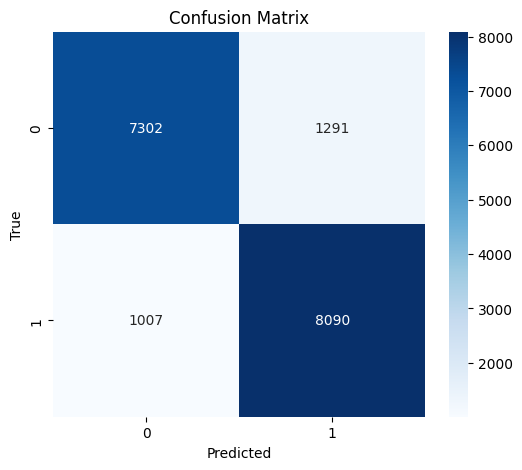

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
